In [10]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.stats import entropy
import scgen
import seaborn as sns
from scipy import stats
import matplotlib
import scipy.sparse as sparse
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.set_figure_params(dpi_save=300)

In [11]:
path_to_save = "../results/Figures/Supplemental Figure 6/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

In [12]:
pbmc = sc.read("../data/train_pbmc.h5ad")
pbmc

AnnData object with n_obs × n_vars = 16893 × 6998 
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [13]:
network = scgen.VAEArith(x_dimension=pbmc.shape[1], z_dimension=100, model_path="../models/scGen/pbmc/CD4T/scgen")
network.restore_model()

INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/CD4T/scgen


In [14]:
scgen_reconstructed_hpoly = sc.read("../data/reconstructed/scGen/hpoly.h5ad")
scgen_reconstructed_hpoly

AnnData object with n_obs × n_vars = 7795 × 7000 
    obs: 'batch', 'cell_label', 'condition'

In [15]:
scgen_reconstructed_salmonella = sc.read("../data/reconstructed/scGen/salmonella.h5ad")
scgen_reconstructed_salmonella

AnnData object with n_obs × n_vars = 7024 × 7000 
    obs: 'batch', 'cell_label', 'condition'

In [16]:
def score(adata, data_name, n_deg=10, n_genes=1000, condition_key="condition", cell_type_key="cell_type",
          conditions={"stim": "stimulated", "ctrl": "control"},
          sortby="median_score"):
    sc.tl.rank_genes_groups(adata, groupby=condition_key, method="wilcoxon", n_genes=n_genes)
    gene_names_up = adata.uns["rank_genes_groups"]['names'][conditions['stim']]
    gene_names_down = adata.uns["rank_genes_groups"]['names'][conditions['ctrl']]
    gene_lfcs_up = adata.uns["rank_genes_groups"]['logfoldchanges'][conditions['stim']]
    gene_lfcs_down = adata.uns["rank_genes_groups"]['logfoldchanges'][conditions['ctrl']]

    gene_names = gene_names_up.tolist()[:n_genes // 2] + gene_names_down.tolist()[:n_genes // 2]
    gene_lfcs = gene_lfcs_up.tolist()[:n_genes // 2] + gene_lfcs_down.tolist()[:n_genes // 2]
    diff_genes_df = pd.DataFrame({"names": gene_names, "lfc": gene_lfcs})
    diff_genes = diff_genes_df["names"].tolist()
    print(len(diff_genes))
    adata_deg = adata[:, diff_genes].copy()
    cell_types = adata_deg.obs[cell_type_key].cat.categories.tolist()
    lfc_temp = np.zeros((len(cell_types), n_genes))
    for j, ct in enumerate(cell_types):
        if cell_type_key == "cell_type":  # if data is pbmc
            stim = adata_deg[(adata_deg.obs[cell_type_key] == ct) &
                             (adata_deg.obs[condition_key] == conditions["stim"])].X.mean(0).A1
            ctrl = adata_deg[(adata_deg.obs[cell_type_key] == ct) &
                             (adata_deg.obs[condition_key] == conditions["ctrl"])].X.mean(0).A1
        else:
            stim = adata_deg[(adata_deg.obs[cell_type_key] == ct) &
                             (adata_deg.obs[condition_key] == conditions["stim"])].X.mean(0)
            ctrl = adata_deg[(adata_deg.obs[cell_type_key] == ct) &
                             (adata_deg.obs[condition_key] == conditions["ctrl"])].X.mean(0)
        lfc_temp[j] = np.abs((stim - ctrl)[None, :])
    norm_lfc = lfc_temp / lfc_temp.sum(0).reshape((1, n_genes))
    ent_scores = entropy(norm_lfc)
    median = np.median(lfc_temp, axis=0)
    med_scores = np.max(np.abs((lfc_temp - median)), axis=0)
    df_score = pd.DataFrame({"genes": adata_deg.var_names.tolist(), "median_score": med_scores,
                             "entropy_score": ent_scores})
    if sortby == "median_score":
        print(df_score.sort_values(by=['median_score'], ascending=False))
        return df_score.sort_values(by=['median_score'], ascending=False).iloc[:n_deg, :]
    else:
        return df_score.sort_values(by=['entropy_score'], ascending=False).iloc[:n_deg, :]

In [17]:
def stacked_violin_plot(recon_data, method, figure, data_name="pbmc", score_type="median_score"):
    if data_name == "pbmc":
        stim_key = "stimulated"
        ctrl_key = "control"
        cell_type_key = "cell_type"
        train = sc.read("../data/train_pbmc.h5ad")
    elif data_name == "hpoly":
        stim_key = "Hpoly.Day10"
        ctrl_key = "Control"
        cell_type_key = "cell_label"
        train = sc.read("../data/train_hpoly.h5ad")
    elif data_name == "salmonella":
        stim_key = "Salmonella"
        ctrl_key = "Control"
        cell_type_key = "cell_label"
        train = sc.read("../data/train_salmonella.h5ad")
    sc.settings.figdir = path_to_save
    conditions = {"ctrl": ctrl_key, "stim": stim_key}

    diff_genes = score(train, data_name, n_deg=10, n_genes=500, cell_type_key=cell_type_key, conditions=conditions,
                       sortby=score_type)
    diff_genes = diff_genes["genes"].tolist()
    
    sc.pl.stacked_violin(recon_data,
                         var_names=diff_genes,
                         groupby="condition",
                         save=f"_{method}_{score_type}_{data_name}.pdf",
                         swap_axes=True,
                         show=True)
    os.rename(src=os.path.join(path_to_save, f"stacked_violin_{method}_{score_type}_{data_name}.pdf"), 
              dst=os.path.join(path_to_save, f"SupplFig6{figure}_{method}_{score_type}_{data_name}.pdf"))

500
        genes  median_score  entropy_score
2       Reg3b      1.445777       2.020220
3       Reg3g      1.284191       2.025026
339    Guca2a      1.116699       1.647844
15       Ang4      1.062519       1.895470
11      Itln1      1.043486       1.929974
254     Fabp6      0.999100       1.953020
22      Lypd8      0.944746       1.779691
406   Cyp3a11      0.873596       0.812936
6        Cd74      0.854462       1.887032
39   AA467197      0.819466       1.690941
68       Mmp7      0.803962       1.296896
24     Ifitm3      0.774517       1.813989
4        Gpx2      0.773346       1.942071
70    Sprr2a3      0.758276       1.519089
61       Clps      0.756948       1.548188
7      Defa17      0.740732       1.998842
20     H2.Eb1      0.721496       1.815763
136  Ifi27l2b      0.718417       1.698762
325     Gstm3      0.714602       1.405664
128    Retnlb      0.700577       1.051973
10      Dmbt1      0.693591       1.873549
13     H2.Ab1      0.675607       1.908819
279    

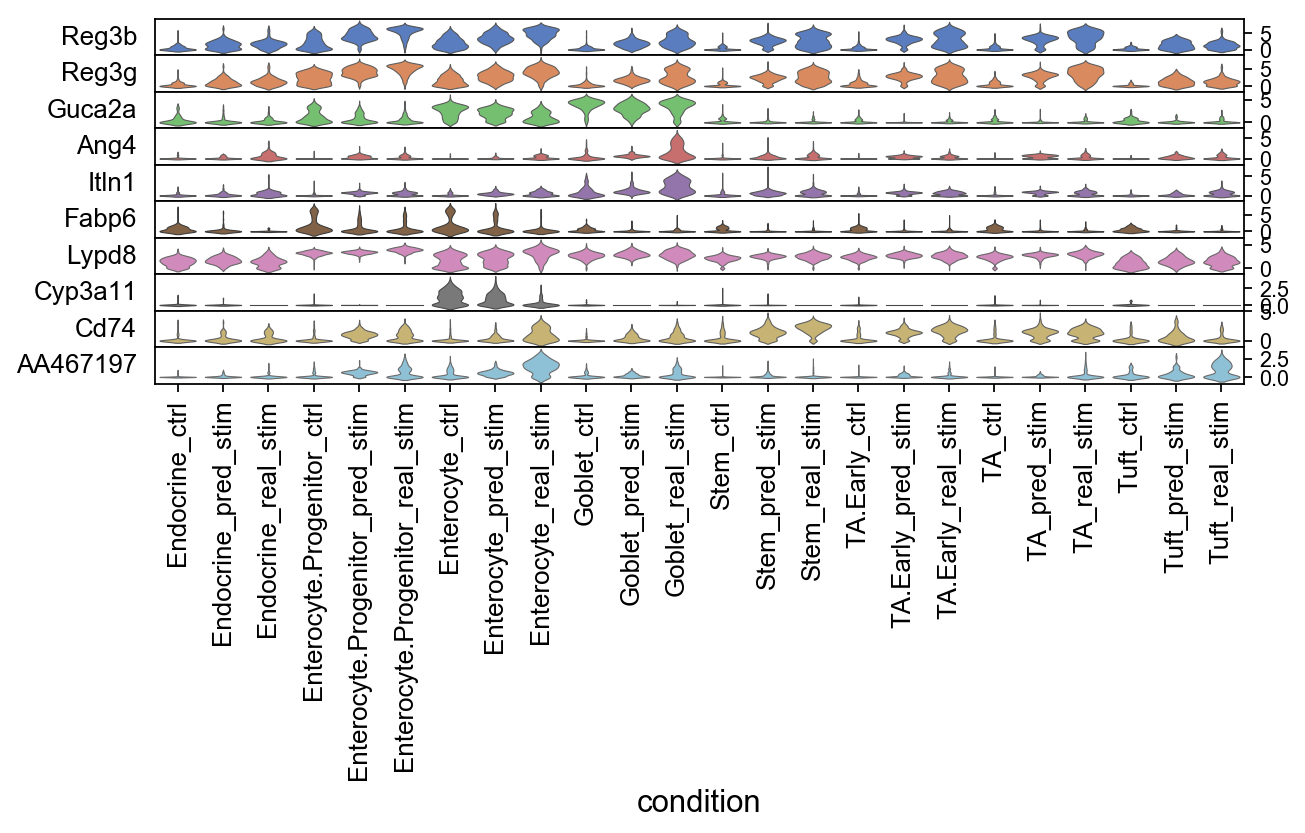

500
              genes  median_score  entropy_score
2             Apoa1      1.222406       1.948721
43              Sst      1.070338       1.764564
0             Reg3b      1.021918       2.072936
96             Cd74      0.837238       1.791013
50           H2.Ab1      0.774975       1.695697
1             Reg3g      0.749949       2.071691
123            Gpx2      0.715026       1.764787
28           Defa24      0.671713       2.012912
348           Tubb5      0.649612       1.264143
3             Fabp1      0.615654       2.022423
285             Mt1      0.602705       1.830883
261            Rps2      0.578277       1.748582
6            Guca2b      0.560820       1.995876
423           Gsta4      0.550142       1.526133
402           Fabp6      0.540978       1.742113
11            Fabp2      0.527815       1.999984
463           Gstm1      0.524555       1.723511
5             Psmb8      0.520191       2.000917
134          H2.Eb1      0.514021       1.678968
39             Z

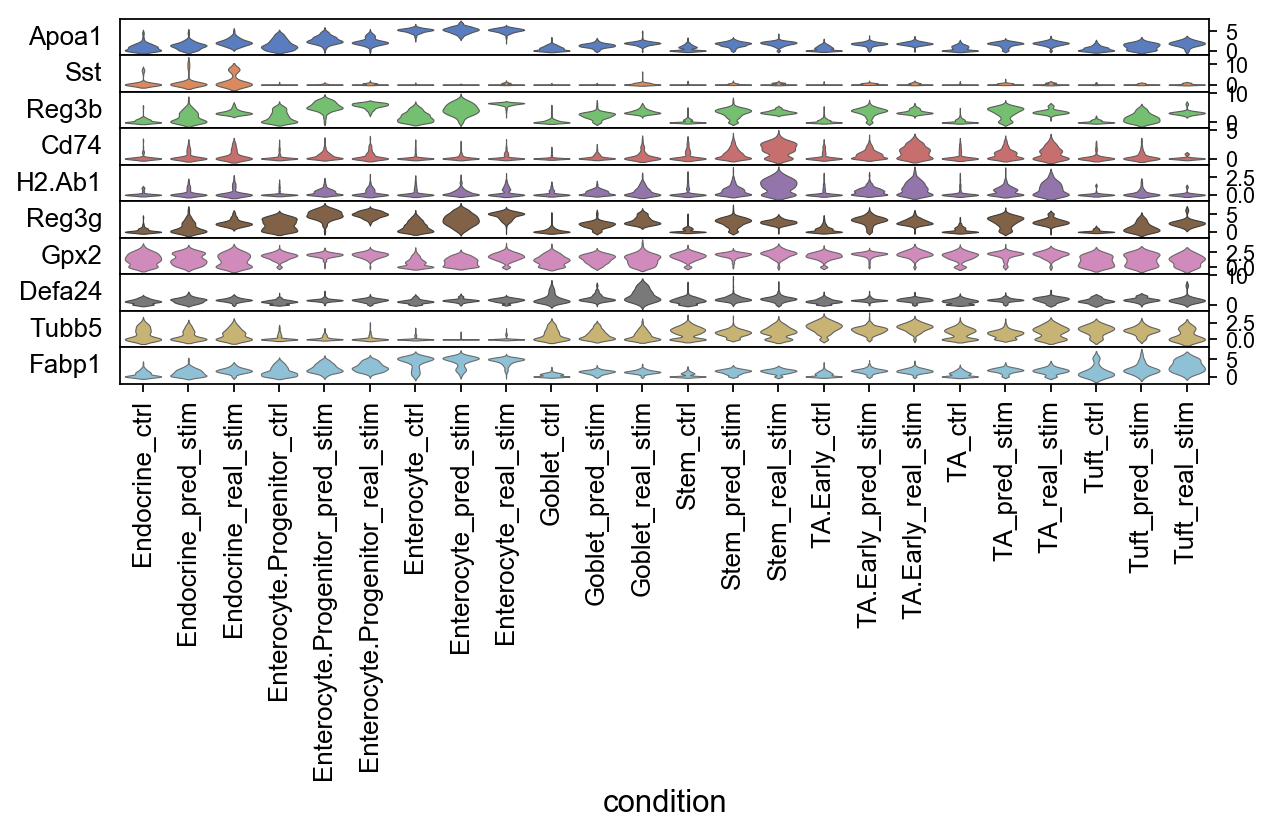

In [18]:
stacked_violin_plot(scgen_reconstructed_hpoly, "scGen", "a", "hpoly", "median_score")
stacked_violin_plot(scgen_reconstructed_salmonella, "scGen", "b", "salmonella", "median_score")